# Benchmarking

In [1]:
from qiskit import QuantumCircuit
import numpy as np
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error, ReadoutError
from qiskit.visualization import plot_histogram 
import typing
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

from qiskit_aer import Aer
from qiskit import transpile
from qiskit_aer.primitives import Sampler
from qiskit.primitives.backend_sampler import BackendSampler
from qiskit.quantum_info import Statevector
from qiskit.circuit import Instruction
from matplotlib import pyplot as plt
from qiskit.quantum_info import state_fidelity, DensityMatrix


In [20]:
import matplotlib.pyplot as plt
import pandas as pd
from lmfit import Model
from pandas import DataFrame


In [21]:
no_noise = NoiseModel()

In [22]:
def steane_enc_8(amp_0: float, amp_1: float, is_ideal: bool):


    if is_ideal == True:
        steane_enc_block = QuantumCircuit(8, 8, name="steane_block")
    else:
        steane_enc_block = QuantumCircuit(8, name="steane_block_noise")


    steane_enc_block.h(0)
    steane_enc_block.h(4)
    steane_enc_block.h(6)

    #steane_enc_block.initialize([amp_0, amp_1], 6)
    steane_enc_block.initialize([amp_0, amp_1], 6)

    steane_enc_block.barrier()

    steane_enc_block.cx(0, 1)
    steane_enc_block.cx(4, 5)
    steane_enc_block.cx(6, 3)

    steane_enc_block.cx(4,2)
    steane_enc_block.cx(6,5)

    steane_enc_block.cx(0,3)
    steane_enc_block.cx(4,1)

    steane_enc_block.cx(3,2)

    steane_enc_block.cx(1,7)
    steane_enc_block.cx(3,7)
    steane_enc_block.cx(5,7)

    steane_enc_block.barrier()

    for i in range(0, 8):
        steane_enc_block.h(i)
        #steane_enc_block.measure(i,0)
    steane_enc_block.barrier()
    # steane_enc_block.measure(7,0)


    #print(steane_enc_block)

    return steane_enc_block

In [23]:
def steane_enc_7(amp_0: float, amp_1: float, is_ideal: bool):


    if is_ideal == True:
        steane_enc_block = QuantumCircuit(7, 7, name="steane_block")
    else:
        steane_enc_block = QuantumCircuit(7, name="steane_block_noise")

    for i in range(1,4):
        steane_enc_block.h(i)
    
    steane_enc_block.h(6)
    steane_enc_block.initialize([amp_0, amp_1], 6)

    steane_enc_block.barrier()

    steane_enc_block.cx(1,0)
    steane_enc_block.cx(2,4)
    steane_enc_block.cx(6,5)

    steane_enc_block.cx(2,0)
    steane_enc_block.cx(3,5)
    steane_enc_block.cx(6,4)
    steane_enc_block.cx(2,6)
    steane_enc_block.cx(3,4)
    steane_enc_block.cx(1,5)
    steane_enc_block.cx(1,6)
    steane_enc_block.cx(3,0)
    
    steane_enc_block.barrier()

    # switch to measuring in other basis
    for i in range(0, 7):
        steane_enc_block.h(i)

    #print(steane_enc_block)
    return steane_enc_block



In [24]:
def create_h_block(num: int, is_ideal: bool):
    if (is_ideal == 1):
        h_block = QuantumCircuit(num, num, name="h_block")
    else:
        h_block = QuantumCircuit(num, name="h_block_noise")

    for i in range(0, num):
        h_block.h(i)

    # convert to instruction
    h_block_instr = h_block.to_instruction()
    return h_block_instr

In [25]:
# applies cz to n qubits
def create_cz_block(num: int, is_ideal: bool):
    if (is_ideal == 1):
        cz_block = QuantumCircuit(num*2, num*2, name="cz_block")
    else:
        cz_block = QuantumCircuit(num*2, name="cz_block_noise")
    
    for i in range(0, num):
        cz_block.cz(i, i + num)
        print(num)

    # convert to instruction
    cz_block_instr = cz_block.to_instruction()
    return cz_block_instr

In [26]:
# applies identity 
def create_id_block(num: int, is_ideal: bool):

    if (is_ideal == 1):
        id_block = QuantumCircuit(num, num, name = "id_block")
    else:
        id_block = QuantumCircuit(num, name = "id_block")
    

    for i in range(0, num):
        id_block.id(i)

    id_block_instr = id_block.to_instruction()
    return id_block_instr

In [27]:
# applies x 
def create_x_block(num: int, is_ideal: bool):
    if (is_ideal == 1):
        x_block = QuantumCircuit(num, num, name = "x_block")
    else:
        x_block = QuantumCircuit(num, name = "x_block")
    

    for i in range(0, num):
        x_block.x(i)

    x_block_instr = x_block.to_instruction()
    return x_block_instr

In [28]:
def prepare_state(qc_prep: QuantumCircuit, encode_block: Instruction, log_block: Instruction, num: int, is_ideal: bool):

    if (is_ideal == 1):
        qc_prep.append(create_id_block(num, is_ideal), range(0,num), range(0,num))
        qc_prep.append(encode_block, range(0,num), range(0,num))
        qc_prep.append(create_id_block(num, is_ideal), range(0,num), range(0,num))
        qc_prep.append(log_block,range(0,num), range(0,num))
        qc_prep.draw('mpl')
    else:
        qc_prep.append(create_id_block(num, is_ideal), range(0,num))
        qc_prep.append(encode_block, range(0,num))
        qc_prep.append(create_id_block(num, is_ideal), range(0,num))
        qc_prep.append(log_block,range(0,num))
        qc_prep.draw('mpl')

In [29]:

theta = np.arctan(np.sqrt((np.sqrt(5) - 1) / 2))
amp_0_theta = np.cos(theta/2)
amp_1_theta = np.sin(theta/2)

print(Statevector([amp_0_theta, amp_1_theta]))

steane_intr_theta_ideal = steane_enc_8(amp_0_theta, amp_1_theta, True).to_instruction()
steane_intr_theta_ideal_7 = steane_enc_7(amp_0_theta, amp_1_theta, True).to_instruction()

steane_intr_theta_n = steane_enc_8(amp_0_theta, amp_1_theta, False).to_instruction()
steane_intr_theta_n_7 = steane_enc_7(amp_0_theta, amp_1_theta, False).to_instruction()

Statevector([0.94502682+0.j, 0.32699283+0.j],
            dims=(2,))


In [30]:
steane_block_instr = steane_enc_8(amp_0_theta, amp_1_theta, True).to_instruction()
steane_block_instr_7 = steane_enc_7(amp_0_theta, amp_1_theta, True).to_instruction()
steane_block_instr_noise = steane_enc_8(amp_0_theta, amp_1_theta, False).to_instruction()
steane_block_instr_7_noise = steane_enc_7(amp_0_theta, amp_1_theta, False).to_instruction()


In [31]:

def preparation_results_2(num: int, is_ideal: bool, is_counts:bool, encoding: Instruction, noise_model: NoiseModel, shots = 1000):


    qc = QuantumCircuit(num,num)

    state = []
    counts = []

  
    prepare_state(qc, encoding, create_id_block(num, is_ideal), num, is_ideal)

    if (is_counts == True):
        for j in range(0,7):
            qc.measure(j,j)


    if is_counts == False:
        if is_ideal == True:
            simulator = Aer.get_backend('statevector_simulator')
            steane_t = transpile(qc, simulator)
            job = simulator.run(steane_t, shots=shots)
            result = job.result()
            # counts = result.get_counts()
            state = result.get_statevector()
            
            # counts_arr.append(counts)
        else:
            # for j in range(0,7):
            #     qc_arr[i].measure(j,j)
            qc.save_statevector(label='state_post', pershot=True, conditional=True)
            backend = AerSimulator(noise_model=noise_model)
            transpiled = transpile(qc, backend)
            job = backend.run(transpiled, shots=shots)
            result = job.result()
            # state = result.get_statevector()
            # state_arr.append(state)
            state = result.data()['state_post']
            #print(state)
            for shot in state['0x0']:
                state = shot.data
    else:
        backend = AerSimulator(noise_model=noise_model)
        transpiled = transpile(qc, backend)
        job = backend.run(transpiled, shots=shots)
        result = job.result()
        counts = result.get_counts()
        
        

    return [qc, state, counts]

In [32]:

def preparation_results_2(num: int, is_ideal: bool, is_counts:bool, encoding: Instruction, noise_model: NoiseModel, shots = 1000):


    qc = QuantumCircuit(num,num)

    state = []
    counts = []

  
    prepare_state(qc, encoding, create_id_block(num, is_ideal), num, is_ideal)

    if (is_counts == True):
        for j in range(0,7):
            qc.measure(j,j)


    if is_counts == False:
        if is_ideal == True:
            simulator = Aer.get_backend('statevector_simulator')
            steane_t = transpile(qc, simulator)
            job = simulator.run(steane_t, shots=shots)
            result = job.result()
            # counts = result.get_counts()
            state = result.get_statevector()
            
            # counts_arr.append(counts)
        else:
            # for j in range(0,7):
            #     qc_arr[i].measure(j,j)
            qc.save_statevector(label='state_post', pershot=True, conditional=True)
            backend = AerSimulator(noise_model=noise_model)
            transpiled = transpile(qc, backend)
            job = backend.run(transpiled, shots=shots)
            result = job.result()
            # state = result.get_statevector()
            # state_arr.append(state)
            state = result.data()['state_post']
            # print(state)
            for shot in state['0x0']:
                state = shot.data
                # print(state)
    else:
        backend = AerSimulator(noise_model=noise_model)
        transpiled = transpile(qc, backend)
        job = backend.run(transpiled, shots=shots)
        result = job.result()
        counts = result.get_counts()
        

    return [qc, state, counts]

In [40]:

def explore_error(reps: int, noise_list: list, error_list, err_size: int, shots=1000):

    fid_theta_7_sv_df = pd.DataFrame(index= error_list, columns = range(0,reps))
    fid_theta_8_sv_df = pd.DataFrame(index= error_list, columns = range(0,reps))

    fid_theta_7_sv_df.index.name = "physical error"
    fid_theta_8_sv_df.index.name = "physical error"

    fid_theta_7_sv_list = []
    fid_theta_8_sv_list = []

    iterations = err_size * reps

    count = 0
    for i in range(0,iterations):
        qc_arr_theta_7_ideal_sv = []
        qc_arr_theta_7_n_sv = []
        qc_arr_theta_8_ideal_sv = []
        qc_arr_theta_8_n_sv = []


        [qc_arr_theta_7_ideal_sv, 
        state_arr_theta_7_ideal_sv, 
        counts_arr_theta_7_ideal_sv] = preparation_results_2(num = 7, 
                                                            is_ideal = True, 
                                                            is_counts = False, 
                                                            encoding = steane_intr_theta_ideal_7, 
                                                            noise_model = no_noise,
                                                            shots = shots)



        [qc_arr_theta_7_n_sv, 
        state_arr_theta_7_n_sv, 
        counts_arr_theta_7_n_sv] = preparation_results_2(num = 7, 
                                                        is_ideal = False, 
                                                        is_counts = False, 
                                                        encoding = steane_intr_theta_n_7, 
                                                        noise_model = noise_list[i % err_size],
                                                        shots = shots)
        
        
        

        [qc_arr_theta_8_ideal_sv, 
        state_arr_theta_8_ideal_sv, 
        counts_arr_theta_8_ideal_sv] = preparation_results_2(num = 8, 
                                                            is_ideal = True, 
                                                            is_counts = False, 
                                                            encoding = steane_intr_theta_ideal, 
                                                            noise_model = no_noise,
                                                            shots = shots)



        [qc_arr_theta_8_n_sv, 
        state_arr_theta_8_n_sv, 
        counts_arr_theta_8_n_sv] = preparation_results_2(num = 8, 
                                                        is_ideal = False, 
                                                        is_counts = False, 
                                                        encoding = steane_intr_theta_n, 
                                                        noise_model = noise_list[i % err_size],
                                                        shots = shots)


        # print(state_arr_theta_7_ideal_sv)
        sv_theta_7_ideal = Statevector(state_arr_theta_7_ideal_sv)
        sv_theta_7_noise = Statevector(state_arr_theta_7_n_sv)
        sv_theta_8_ideal = Statevector(state_arr_theta_8_ideal_sv)
        sv_theta_8_noise = Statevector(state_arr_theta_8_n_sv)
        fid_7 = state_fidelity(sv_theta_7_ideal, sv_theta_7_noise)
        fid_8 = state_fidelity(sv_theta_8_ideal, sv_theta_8_noise)

        fid_theta_7_sv_list.append(fid_7)
        fid_theta_8_sv_list.append(fid_8)

        print(fid_7)

        #print(len(fid_theta_7_sv_list))
        

        if (i % err_size == (err_size - 1)):

            fid_theta_7_sv_df[count] = fid_theta_7_sv_list
            fid_theta_8_sv_df[count] = fid_theta_8_sv_list

            fid_theta_7_sv_list = []
            fid_theta_8_sv_list = []
            count +=  1
    
    return fid_theta_7_sv_df, fid_theta_8_sv_df
                

            


        








# preliminary look at depolarizing noise

In [ ]:
err_list_size = 30
reps = 50
error_list = np.linspace(10**(-5), 10**(-1), err_list_size)
noise_list = []

for error in error_list:
    readout_err = ReadoutError([[0.98, 0.02],  # P(measured 0 | actual 0), P(1 | 0)
                                [0.02, 0.98]]) # P(0 | 1), P(1 | 1)

    noise_model = NoiseModel()

    noise_model.add_all_qubit_quantum_error(depolarizing_error(error,1), ['id'])
    noise_model.add_all_qubit_quantum_error(depolarizing_error(error,1), ['h'])
    noise_model.add_all_qubit_quantum_error(depolarizing_error(error,2),['cz'])
    noise_model.add_all_qubit_quantum_error(depolarizing_error(error,2),['cx'])
    
    noise_list.append(noise_model)

In [ ]:

fid_theta_7_sv_df, fid_theta_8_sv_df = explore_error(reps, noise_list,  error_list, err_list_size, shots = 10**(3))

In [ ]:
from lmfit import Model
from pandas import DataFrame

In [ ]:
def decay(x, a, r, b):
    y = a * np.exp(-x * r) + b
    return y

In [ ]:
fid_theta_7_sv_df['mean'] = fid_theta_7_sv_df.mean(axis=1)
fid_theta_8_sv_df['mean'] = fid_theta_8_sv_df.mean(axis=1)

fid_model = Model(decay)
#print(f'independent variables: {decay_model.independent_vars}')


params = fid_model.make_params()

result_7 = fid_model.fit(fid_theta_7_sv_df['mean'], x=np.array(list(error_list)), a = 1, b = 0, r = 5)
result_8 = fid_model.fit(fid_theta_8_sv_df['mean'], x=np.array(list(error_list)), a = 1, b = 0, r = 5)

print(result_7.fit_report())
print(result_8.fit_report())

#plt.plot(error_list, result_7.init_fit, '--', label='initial fit')
plt.plot(error_list, result_7.best_fit, '--', label='7 best fit', color = "blue")
plt.plot(error_list, result_8.best_fit, '--', label='7 best fit', color = "red")


plt.scatter(x = error_list, y=fid_theta_7_sv_df['mean'], label="7 qubit")
plt.scatter(x = error_list, y=fid_theta_8_sv_df['mean'], label="8 qubit")
plt.title("Fidelity of Logical Steane State vs. Depolarizing Noise Error")
plt.xlabel("Depolarizing Noise Error")
plt.ylabel("Fidelity of Steane State")
plt.legend()

plt.ylim(0,1.1)

In [41]:
def get_sample_error_rate(fidelity_df: DataFrame, shots = 1000):
    sample_err_rate = []
    for fid in fidelity_df['mean']:
        # print(fid)
        sample_err_rate.append((fid)*(1 - fid) / shots)
    
    return sample_err_rate
    


In [ ]:
# use plt error barrs
# use more shots 
#  about benchmarking logical gates for steane code
# error map for 1 and 2 qubit 
# have numbers for errors of each gate (H, CZ, meas)
# find way to measure effective logical error rate that isn't repeating QEC enc rounds



sample_err_rate_7 = get_sample_error_rate(fid_theta_7_sv_df)


fidelity_results_7 = fid_theta_7_sv_df['mean']


depol_probs = sorted(error_list)
fidelities_7 = [1 - fidelity_results_7.loc[p] for p in depol_probs]


print(fidelities_7)

# Uncertainty Calculations
unc_7 = [1.96 * np.sqrt(i) for i in sample_err_rate_7]



plt.figure(figsize=(7, 5))
plt.errorbar(
    depol_probs,
    fidelities_7,
    yerr=unc_7,
    fmt='o-',           # circle marker and solid line
    capsize=3,          # length of the little “T” caps on each bar
    elinewidth=1,       # width of the error‐bar lines
    markeredgewidth=1
)
plt.xlabel("Depolarizing Noise Probability", fontsize=12)
plt.ylabel("Infidelity", fontsize=12)
plt.title("Infidelity vs Depolarizing noise probability")
plt.grid(True)
plt.tight_layout()
plt.yscale('log')
plt.xscale('log')
plt.show()

### p*11


In [43]:

err_list_size = 15
reps = 50
error_list = np.logspace((-3), (-2), err_list_size)
noise_list = []

for error in error_list:
    # readout_err = ReadoutError([[0.98, 0.02],  # P(measured 0 | actual 0), P(1 | 0)
    #                             [0.02, 0.98]]) # P(0 | 1), P(1 | 1)

    noise_model = NoiseModel()

    error2 = error*11

    noise_model.add_all_qubit_quantum_error(depolarizing_error(error,1), ['id'])
    noise_model.add_all_qubit_quantum_error(depolarizing_error(error,1), ['h'])
    noise_model.add_all_qubit_quantum_error(depolarizing_error(error2,2),['cz'])
    noise_model.add_all_qubit_quantum_error(depolarizing_error(error2,2),['cx'])

    readout_err = ReadoutError([[1-error2, error2],  # P(measured 0 | actual 0), P(1 | 0)
                            [error2, 1-error2]]) # P(0 | 1), P(1 | 1)
    
    for i in range(0,7):
        noise_model.add_readout_error(readout_err, [i])

    
    noise_list.append(noise_model)

In [44]:

fid_theta_7_sv_df, fid_theta_8_sv_df = explore_error(reps, noise_list,  error_list, err_list_size, shots = 10**(3))

c:\Users\diyan\anaconda3\lib\site-packages\qiskit\circuit\quantumcircuit.py:3263: RuntimeWarning: Cregbundle set to False since an instruction needs to refer to individual classical wire
  return circuit_drawer(


1.0000000000000013
1.0000000000000013
1.0000000000000013
1.0000000000000013
1.0000000000000013
1.0000000000000013
1.0000000000000013
3.0814879110195774e-33
1.0000000000000013
3.410303840489042e-66
1.0000000000000013
6.516251156900418e-36
2.9780037700955673e-36
1.261392262609277e-66
4.794036587204811e-94
1.0000000000000013
1.0000000000000013
1.0000000000000013
1.0000000000000013
1.0000000000000013
1.0000000000000013
1.0000000000000013
1.0000000000000013
1.0000000000000013
1.0000000000000013
2.0999870863551006e-67
1.0000000000000013
2.499082123783503e-67
1.0000000000000013
6.516251156900418e-36
1.0000000000000013
1.0000000000000013
1.0000000000000013
1.0000000000000013
1.0000000000000013
1.0000000000000013
1.0000000000000013
1.0000000000000013
1.0000000000000013
3.5446510324698294e-35
1.0000000000000013
1.0000000000000013
3.5446510324698294e-35
5.298348702675184e-67
0.38196601125010576
1.0000000000000013
1.0000000000000013
1.0000000000000013
1.106288833869253e-65
1.5010011319609632e-32
1

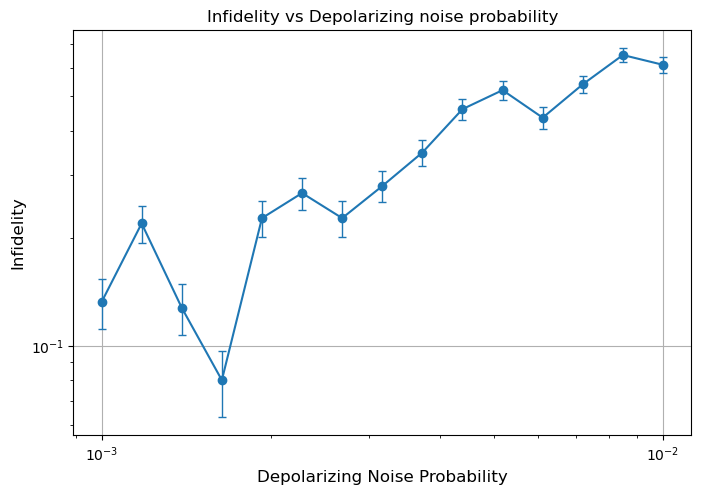

In [45]:

fid_theta_7_sv_df['mean'] = fid_theta_7_sv_df.mean(axis=1)
fid_theta_8_sv_df['mean'] = fid_theta_8_sv_df.mean(axis=1)


sample_err_rate_7 = get_sample_error_rate(fid_theta_7_sv_df)


fidelity_results_7 = fid_theta_7_sv_df['mean']


depol_probs = sorted(error_list)
fidelities_7 = [1 - fidelity_results_7.loc[p] for p in depol_probs]


#print(fidelities_7)

# Uncertainty Calculations
unc_7 = [1.96 * np.sqrt(abs(i)) for i in sample_err_rate_7]
# [print(i) for i in sample_err_rate_7]


plt.figure(figsize=(7, 5))
plt.errorbar(
    depol_probs,
    fidelities_7,
    yerr=unc_7,
    fmt='o-',           # circle marker and solid line
    capsize=3,          # length of the little “T” caps on each bar
    elinewidth=1,       # width of the error‐bar lines
    markeredgewidth=1
)
plt.xlabel("Depolarizing Noise Probability", fontsize=12)
plt.ylabel("Infidelity", fontsize=12)
plt.title("Infidelity vs Depolarizing noise probability")
plt.grid(True)
plt.tight_layout()
plt.yscale('log')
plt.xscale('log')
plt.show()

p * 12

In [66]:
err_list_size = 15
reps = 50
error_list = np.logspace((-3), (-2), err_list_size)
noise_list = []

for error in error_list:
    # readout_err = ReadoutError([[0.98, 0.02],  # P(measured 0 | actual 0), P(1 | 0)
    #                             [0.02, 0.98]]) # P(0 | 1), P(1 | 1)

    noise_model = NoiseModel()

    error2 = error * 12

    noise_model.add_all_qubit_quantum_error(depolarizing_error(error,1), ['id'])
    noise_model.add_all_qubit_quantum_error(depolarizing_error(error,1), ['h'])
    noise_model.add_all_qubit_quantum_error(depolarizing_error(error2,2),['cz'])
    noise_model.add_all_qubit_quantum_error(depolarizing_error(error2,2),['cx'])

    readout_err = ReadoutError([[1-error2, error2],  # P(measured 0 | actual 0), P(1 | 0)
                            [error2, 1-error2]]) # P(0 | 1), P(1 | 1)
    
    for i in range(0,7):
        noise_model.add_readout_error(readout_err, [i])

    
    noise_list.append(noise_model)

In [67]:

fid_theta_7_sv_df, fid_theta_8_sv_df = explore_error(reps, noise_list,  error_list, err_list_size, shots = 10**(3))

c:\Users\diyan\anaconda3\lib\site-packages\qiskit\circuit\quantumcircuit.py:3263: RuntimeWarning: Cregbundle set to False since an instruction needs to refer to individual classical wire
  return circuit_drawer(


1.0000000000000013
1.0000000000000013
1.0000000000000013
1.0000000000000013
3.5446510324698294e-35
1.0000000000000013
1.0000000000000013
1.0000000000000013
1.0000000000000013
1.106288833869253e-65
9.269025206451845e-33
1.0000000000000013
1.0000000000000013
5.247839359203893e-32
1.0000000000000013
1.0000000000000013
2.7082966901915313e-66
1.0000000000000013
0.6180339887498956
1.0000000000000013
1.0000000000000013
1.0000000000000013
1.0000000000000013
1.0000000000000013
1.0000000000000013
7.476605632960952e-69
1.0000000000000013
1.0000000000000013
2.9339282580375996e-65
1.0000000000000013
1.0000000000000013
1.0000000000000013
1.0000000000000013
1.0000000000000013
1.0000000000000013
1.0000000000000013
1.8726705418768793e-96
1.1447007535292892e-71
9.71453298192309e-66
1.0000000000000013
2.041084752394e-32
9.495567745759799e-66
1.5010011319609632e-32
1.0000000000000013
3.0907306894537255e-67
1.0000000000000013
1.0000000000000013
1.49975978266186e-32
1.0000000000000013
1.9234685566231086e-66

KeyboardInterrupt: 

In [ ]:

fid_theta_7_sv_df['mean'] = fid_theta_7_sv_df.mean(axis=1)
fid_theta_8_sv_df['mean'] = fid_theta_8_sv_df.mean(axis=1)


sample_err_rate_7 = get_sample_error_rate(fid_theta_7_sv_df)


fidelity_results_7 = fid_theta_7_sv_df['mean']


depol_probs = sorted(error_list)
fidelities_7 = [1 - fidelity_results_7.loc[p] for p in depol_probs]


#print(fidelities_7)

# Uncertainty Calculations
unc_7 = [1.96 * np.sqrt(abs(i)) for i in sample_err_rate_7]
# [print(i) for i in sample_err_rate_7]


plt.figure(figsize=(7, 5))
plt.errorbar(
    depol_probs,
    fidelities_7,
    yerr=unc_7,
    fmt='o-',           # circle marker and solid line
    capsize=3,          # length of the little “T” caps on each bar
    elinewidth=1,       # width of the error‐bar lines
    markeredgewidth=1
)
plt.xlabel("Depolarizing Noise Probability", fontsize=12)
plt.ylabel("Infidelity", fontsize=12)
plt.title("Infidelity vs Depolarizing noise probability")
plt.grid(True)
plt.tight_layout()
plt.yscale('log')
plt.xscale('log')
plt.show()

## p*13

In [ ]:

err_list_size = 15
reps = 50
error_list = np.logspace((-3), (-2), err_list_size)
noise_list = []

for error in error_list:
    # readout_err = ReadoutError([[0.98, 0.02],  # P(measured 0 | actual 0), P(1 | 0)
    #                             [0.02, 0.98]]) # P(0 | 1), P(1 | 1)

    noise_model = NoiseModel()

    error2 = error*13

    noise_model.add_all_qubit_quantum_error(depolarizing_error(error,1), ['id'])
    noise_model.add_all_qubit_quantum_error(depolarizing_error(error,1), ['h'])
    noise_model.add_all_qubit_quantum_error(depolarizing_error(error2,2),['cz'])
    noise_model.add_all_qubit_quantum_error(depolarizing_error(error2,2),['cx'])

    readout_err = ReadoutError([[1-error2, error2],  # P(measured 0 | actual 0), P(1 | 0)
                            [error2, 1-error2]]) # P(0 | 1), P(1 | 1)
    
    for i in range(0,7):
        noise_model.add_readout_error(readout_err, [i])

    
    noise_list.append(noise_model)

In [ ]:
fid_theta_7_sv_df, fid_theta_8_sv_df = explore_error(reps, noise_list,  error_list, err_list_size, shots = 10**(3))

In [ ]:

fid_theta_7_sv_df['mean'] = fid_theta_7_sv_df.mean(axis=1)
fid_theta_8_sv_df['mean'] = fid_theta_8_sv_df.mean(axis=1)


sample_err_rate_7 = get_sample_error_rate(fid_theta_7_sv_df)


fidelity_results_7 = fid_theta_7_sv_df['mean']


depol_probs = sorted(error_list)
fidelities_7 = [1 - fidelity_results_7.loc[p] for p in depol_probs]


#print(fidelities_7)

# Uncertainty Calculations
unc_7 = [1.96 * np.sqrt(abs(i)) for i in sample_err_rate_7]
# [print(i) for i in sample_err_rate_7]


plt.figure(figsize=(7, 5))
plt.errorbar(
    depol_probs,
    fidelities_7,
    yerr=unc_7,
    fmt='o-',           # circle marker and solid line
    capsize=3,          # length of the little “T” caps on each bar
    elinewidth=1,       # width of the error‐bar lines
    markeredgewidth=1
)
plt.xlabel("Depolarizing Noise Probability", fontsize=12)
plt.ylabel("Infidelity", fontsize=12)
plt.title("Infidelity vs Depolarizing noise probability")
plt.grid(True)
plt.tight_layout()
plt.yscale('log')
plt.xscale('log')
plt.show()

## p*14

In [ ]:

err_list_size = 15
reps = 50
error_list = np.logspace((-3), (-2), err_list_size)
noise_list = []

for error in error_list:
    # readout_err = ReadoutError([[0.98, 0.02],  # P(measured 0 | actual 0), P(1 | 0)
    #                             [0.02, 0.98]]) # P(0 | 1), P(1 | 1)

    noise_model = NoiseModel()

    error2 = error*14

    noise_model.add_all_qubit_quantum_error(depolarizing_error(error,1), ['id'])
    noise_model.add_all_qubit_quantum_error(depolarizing_error(error,1), ['h'])
    noise_model.add_all_qubit_quantum_error(depolarizing_error(error2,2),['cz'])
    noise_model.add_all_qubit_quantum_error(depolarizing_error(error2,2),['cx'])

    readout_err = ReadoutError([[1-error2, error2],  # P(measured 0 | actual 0), P(1 | 0)
                            [error2, 1-error2]]) # P(0 | 1), P(1 | 1)
    
    for i in range(0,7):
        noise_model.add_readout_error(readout_err, [i])

    
    noise_list.append(noise_model)

In [ ]:
fid_theta_7_sv_df, fid_theta_8_sv_df = explore_error(reps, noise_list,  error_list, err_list_size, shots = 10**(3))

In [ ]:

fid_theta_7_sv_df['mean'] = fid_theta_7_sv_df.mean(axis=1)
fid_theta_8_sv_df['mean'] = fid_theta_8_sv_df.mean(axis=1)


sample_err_rate_7 = get_sample_error_rate(fid_theta_7_sv_df)


fidelity_results_7 = fid_theta_7_sv_df['mean']


depol_probs = sorted(error_list)
fidelities_7 = [1 - fidelity_results_7.loc[p] for p in depol_probs]


#print(fidelities_7)

# Uncertainty Calculations
unc_7 = [1.96 * np.sqrt(abs(i)) for i in sample_err_rate_7]
# [print(i) for i in sample_err_rate_7]


plt.figure(figsize=(7, 5))
plt.errorbar(
    depol_probs,
    fidelities_7,
    yerr=unc_7,
    fmt='o-',           # circle marker and solid line
    capsize=3,          # length of the little “T” caps on each bar
    elinewidth=1,       # width of the error‐bar lines
    markeredgewidth=1
)
plt.xlabel("Depolarizing Noise Probability", fontsize=12)
plt.ylabel("Infidelity", fontsize=12)
plt.title("Infidelity vs Depolarizing noise probability")
plt.grid(True)
plt.tight_layout()
plt.yscale('log')
plt.xscale('log')
plt.show()

## p*15

In [ ]:

err_list_size = 15
reps = 50
error_list = np.logspace((-3), (-2), err_list_size)
noise_list = []

for error in error_list:
    # readout_err = ReadoutError([[0.98, 0.02],  # P(measured 0 | actual 0), P(1 | 0)
    #                             [0.02, 0.98]]) # P(0 | 1), P(1 | 1)

    noise_model = NoiseModel()

    error2 = error*15

    noise_model.add_all_qubit_quantum_error(depolarizing_error(error,1), ['id'])
    noise_model.add_all_qubit_quantum_error(depolarizing_error(error,1), ['h'])
    noise_model.add_all_qubit_quantum_error(depolarizing_error(error2,2),['cz'])
    noise_model.add_all_qubit_quantum_error(depolarizing_error(error2,2),['cx'])

    readout_err = ReadoutError([[1-error2, error2],  # P(measured 0 | actual 0), P(1 | 0)
                            [error2, 1-error2]]) # P(0 | 1), P(1 | 1)
    
    for i in range(0,7):
        noise_model.add_readout_error(readout_err, [i])

    
    noise_list.append(noise_model)

In [ ]:
fid_theta_7_sv_df, fid_theta_8_sv_df = explore_error(reps, noise_list,  error_list, err_list_size, shots = 10**(3))

In [ ]:

fid_theta_7_sv_df['mean'] = fid_theta_7_sv_df.mean(axis=1)
fid_theta_8_sv_df['mean'] = fid_theta_8_sv_df.mean(axis=1)


sample_err_rate_7 = get_sample_error_rate(fid_theta_7_sv_df)


fidelity_results_7 = fid_theta_7_sv_df['mean']


depol_probs = sorted(error_list)
fidelities_7 = [1 - fidelity_results_7.loc[p] for p in depol_probs]


#print(fidelities_7)

# Uncertainty Calculations
unc_7 = [1.96 * np.sqrt(abs(i)) for i in sample_err_rate_7]
# [print(i) for i in sample_err_rate_7]


plt.figure(figsize=(7, 5))
plt.errorbar(
    depol_probs,
    fidelities_7,
    yerr=unc_7,
    fmt='o-',           # circle marker and solid line
    capsize=3,          # length of the little “T” caps on each bar
    elinewidth=1,       # width of the error‐bar lines
    markeredgewidth=1
)
plt.xlabel("Depolarizing Noise Probability", fontsize=12)
plt.ylabel("Infidelity", fontsize=12)
plt.title("Infidelity vs Depolarizing noise probability")
plt.grid(True)
plt.tight_layout()
plt.yscale('log')
plt.xscale('log')
plt.show()

# vary pauli error

In [ ]:
from qiskit.quantum_info import Pauli
from qiskit_aer.noise import pauli_error 

In [ ]:
[0.0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2] 

## 2* p (small errors)

In [55]:
pauli_probs = np.logspace(-3,-2, 15)
noise_list = []
for p in pauli_probs:
    # New noise model for each depolarizing probability
    noise_model = NoiseModel()
    
    # Assign 1q and 2q Pauli errors
    noise_1q = [
        (Pauli('I'),    1-p), 
        (Pauli('X'),    2*p/5),
        (Pauli('Y'),    p/5),
        (Pauli('Z'),    2*p/5),
    ]
    
    two_qubit_paulis = []
    for P1 in ['I','X','Y','Z']:
        for P2 in ['I','X','Y','Z']:
            two_qubit_paulis.append((Pauli(P1+P2), None))

    p2 = 2*p
    noise_2q = []
    for pauli, _ in two_qubit_paulis:
        if pauli.to_label() == 'II':
            prob = 1 - p2
        else:
            prob = p2/15
        noise_2q.append((pauli, prob))
    
    

    # Apply depolarizing error with probability p
    noise_model.add_all_qubit_quantum_error(pauli_error(noise_1q), ['id'])
    noise_model.add_all_qubit_quantum_error(pauli_error(noise_1q), ['h'])
    noise_model.add_all_qubit_quantum_error(pauli_error(noise_2q), ['cz']) 
    noise_model.add_all_qubit_quantum_error(pauli_error(noise_2q), ['cx']) 

    # Keep readout error constant
    noise_model.add_readout_error(readout_err, [0])
    noise_model.add_readout_error(readout_err, [1])
    
    noise_list.append(noise_model)

In [56]:
fid_theta_7_sv_df, fid_theta_8_sv_df = explore_error(reps, noise_list,  error_list, err_list_size, shots = 10**(3))

c:\Users\diyan\anaconda3\lib\site-packages\qiskit\circuit\quantumcircuit.py:3263: RuntimeWarning: Cregbundle set to False since an instruction needs to refer to individual classical wire
  return circuit_drawer(


1.0000000000000013
1.0000000000000013
1.0000000000000013
1.0000000000000013
1.0000000000000013
1.0000000000000013
1.0000000000000013
1.0000000000000013
1.0000000000000013
1.0000000000000013
1.0000000000000013
1.0000000000000013
1.0000000000000013
1.0000000000000013
1.0000000000000013
1.0000000000000013
1.0000000000000013
1.0000000000000013
1.0000000000000013
1.0000000000000013
1.0000000000000013
1.0000000000000013
1.0000000000000013
1.0000000000000013
1.0000000000000013
3.5446510324698294e-35
1.0000000000000013
1.0000000000000013
1.0000000000000013
1.0000000000000013
4.994476572137479e-67
1.0000000000000013
1.0000000000000013
1.0000000000000013
1.0000000000000013
1.0000000000000013
1.0000000000000013
1.0000000000000013
1.0000000000000013
1.0000000000000013
3.0814879110195774e-33
1.0000000000000013
1.0000000000000013
1.0000000000000013
1.5010011319609632e-32
1.0000000000000013
1.0000000000000013
1.0000000000000013
1.0000000000000013
1.0000000000000013
1.0000000000000013
1.00000000000000

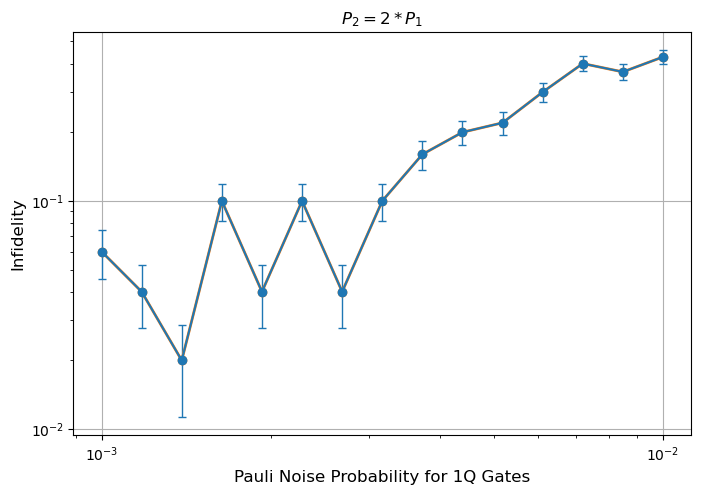

In [60]:
fid_theta_7_sv_df['mean'] = fid_theta_7_sv_df.mean(axis=1)
fid_theta_8_sv_df['mean'] = fid_theta_8_sv_df.mean(axis=1)


sample_err_rate_7 = get_sample_error_rate(fid_theta_7_sv_df)


fidelity_results_7 = fid_theta_7_sv_df['mean']


depol_probs = sorted(error_list)
fidelities_7 = [1 - fidelity_results_7.loc[p] for p in depol_probs]

pauli_probs = sorted(fidelity_results_7.keys())
fidelities = [1 - fidelity_results_7[p] for p in pauli_probs]

unc = [1.96 * np.sqrt(i) for i in sample_err_rate_7]

plt.figure(figsize=(7, 5))
plt.errorbar(
    depol_probs,
    fidelities,
    yerr=unc,
    fmt='o-',           
    capsize=3,          
    elinewidth=1,       
    markeredgewidth=1
)
plt.plot(pauli_probs, fidelities, marker='o', linewidth=2)
plt.xlabel("Pauli Noise Probability for 1Q Gates", fontsize=12)
plt.ylabel("Infidelity", fontsize=12)
plt.title(f"$P_2 = 2 * P_1$")
plt.grid(True)
plt.tight_layout()
plt.yscale('log')
plt.xscale('log')
plt.show()

## 3 * p (small errors)

In [61]:
pauli_probs = np.logspace(-3,-2, 15)
noise_list = []
for p in pauli_probs:
    # New noise model for each depolarizing probability
    noise_model = NoiseModel()
    
    # Assign 1q and 2q Pauli errors
    noise_1q = [
        (Pauli('I'),    1-p), 
        (Pauli('X'),    2*p/5),
        (Pauli('Y'),    p/5),
        (Pauli('Z'),    2*p/5),
    ]
    
    two_qubit_paulis = []
    for P1 in ['I','X','Y','Z']:
        for P2 in ['I','X','Y','Z']:
            two_qubit_paulis.append((Pauli(P1+P2), None))

    p2 = 3*p
    noise_2q = []
    for pauli, _ in two_qubit_paulis:
        if pauli.to_label() == 'II':
            prob = 1 - p2
        else:
            prob = p2/15
        noise_2q.append((pauli, prob))
    
    

    # Apply depolarizing error with probability p
    noise_model.add_all_qubit_quantum_error(pauli_error(noise_1q), ['id'])
    noise_model.add_all_qubit_quantum_error(pauli_error(noise_1q), ['h'])
    noise_model.add_all_qubit_quantum_error(pauli_error(noise_2q), ['cz']) 
    noise_model.add_all_qubit_quantum_error(pauli_error(noise_2q), ['cx']) 

    # Keep readout error constant
    noise_model.add_readout_error(readout_err, [0])
    noise_model.add_readout_error(readout_err, [1])
    
    noise_list.append(noise_model)

In [62]:
fid_theta_7_sv_df, fid_theta_8_sv_df = explore_error(reps, noise_list,  error_list, err_list_size, shots = 10**(3))

c:\Users\diyan\anaconda3\lib\site-packages\qiskit\circuit\quantumcircuit.py:3263: RuntimeWarning: Cregbundle set to False since an instruction needs to refer to individual classical wire
  return circuit_drawer(


1.0000000000000013
1.0000000000000013
1.0000000000000013
1.0000000000000013
1.0000000000000013
1.0000000000000013
1.579700791586406e-32
1.0000000000000013
1.0000000000000013
1.0000000000000013
1.0000000000000013
3.171318042792612e-67
1.579700791586406e-32
1.0000000000000013
1.106288833869253e-65
1.0000000000000013
1.0000000000000013
1.0000000000000013
1.0000000000000013
1.0000000000000013
1.0000000000000013
1.0000000000000013
1.0000000000000013
1.0000000000000013
1.645901843446476e-96
1.0000000000000013
1.0000000000000013
1.0000000000000013
1.49975978266186e-32
1.0000000000000013
1.0000000000000013
1.0000000000000013
1.0000000000000013
1.0000000000000013
1.0000000000000013
1.0000000000000013
1.0000000000000013
7.490682167507517e-96
1.0000000000000013
1.0000000000000013
1.0000000000000013
1.0000000000000013
1.0000000000000013
1.0000000000000013
1.6270555071183654e-67
1.0000000000000013
1.0000000000000013
1.0000000000000013
1.0000000000000013
1.0000000000000013
1.0000000000000013
1.00000

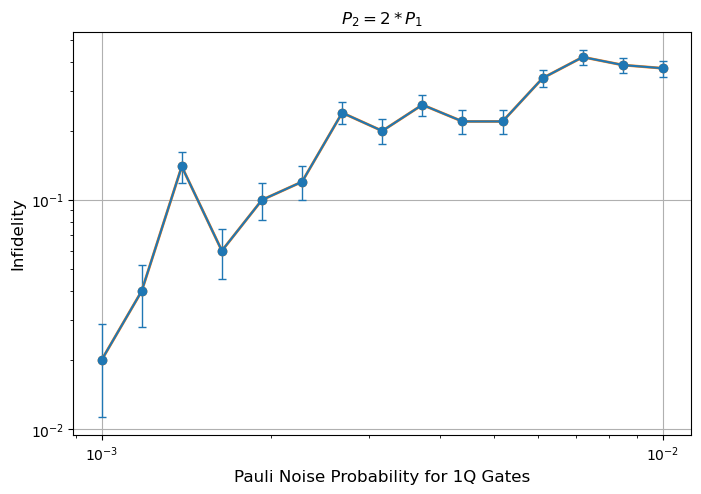

In [63]:
fid_theta_7_sv_df['mean'] = fid_theta_7_sv_df.mean(axis=1)
fid_theta_8_sv_df['mean'] = fid_theta_8_sv_df.mean(axis=1)


sample_err_rate_7 = get_sample_error_rate(fid_theta_7_sv_df)


fidelity_results_7 = fid_theta_7_sv_df['mean']


depol_probs = sorted(error_list)
fidelities_7 = [1 - fidelity_results_7.loc[p] for p in depol_probs]

pauli_probs = sorted(fidelity_results_7.keys())
fidelities = [1 - fidelity_results_7[p] for p in pauli_probs]

unc = [1.96 * np.sqrt(i) for i in sample_err_rate_7]

plt.figure(figsize=(7, 5))
plt.errorbar(
    depol_probs,
    fidelities,
    yerr=unc,
    fmt='o-',           
    capsize=3,          
    elinewidth=1,       
    markeredgewidth=1
)
plt.plot(pauli_probs, fidelities, marker='o', linewidth=2)
plt.xlabel("Pauli Noise Probability for 1Q Gates", fontsize=12)
plt.ylabel("Infidelity", fontsize=12)
plt.title(f"$P_2 = 2 * P_1$")
plt.grid(True)
plt.tight_layout()
plt.yscale('log')
plt.xscale('log')
plt.show()

## 2*q

In [64]:
pauli_probs = [0.0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2] 
noise_list = []
for p in pauli_probs:
    # New noise model for each depolarizing probability
    noise_model = NoiseModel()
    
    # Assign 1q and 2q Pauli errors
    noise_1q = [
        (Pauli('I'),    1-p), 
        (Pauli('X'),    2*p/5),
        (Pauli('Y'),    p/5),
        (Pauli('Z'),    2*p/5),
    ]
    
    two_qubit_paulis = []
    for P1 in ['I','X','Y','Z']:
        for P2 in ['I','X','Y','Z']:
            two_qubit_paulis.append((Pauli(P1+P2), None))

    p2 = 2*p
    noise_2q = []
    for pauli, _ in two_qubit_paulis:
        if pauli.to_label() == 'II':
            prob = 1 - p2
        else:
            prob = p2/15
        noise_2q.append((pauli, prob))
    
    

    # Apply depolarizing error with probability p
    noise_model.add_all_qubit_quantum_error(pauli_error(noise_1q), ['id'])
    noise_model.add_all_qubit_quantum_error(pauli_error(noise_1q), ['h'])
    noise_model.add_all_qubit_quantum_error(pauli_error(noise_2q), ['cz']) 
    noise_model.add_all_qubit_quantum_error(pauli_error(noise_2q), ['cx']) 

    # Keep readout error constant
    noise_model.add_readout_error(readout_err, [0])
    noise_model.add_readout_error(readout_err, [1])
    
    noise_list.append(noise_model)

In [65]:
fid_theta_7_sv_df, fid_theta_8_sv_df = explore_error(reps, noise_list,  error_list, err_list_size, shots = 10**(3))

c:\Users\diyan\anaconda3\lib\site-packages\qiskit\circuit\quantumcircuit.py:3263: RuntimeWarning: Cregbundle set to False since an instruction needs to refer to individual classical wire
  return circuit_drawer(


KeyError: '0x0'

In [ ]:
fid_theta_7_sv_df['mean'] = fid_theta_7_sv_df.mean(axis=1)
fid_theta_8_sv_df['mean'] = fid_theta_8_sv_df.mean(axis=1)


sample_err_rate_7 = get_sample_error_rate(fid_theta_7_sv_df)


fidelity_results_7 = fid_theta_7_sv_df['mean']


depol_probs = sorted(error_list)
fidelities_7 = [1 - fidelity_results_7.loc[p] for p in depol_probs]

pauli_probs = sorted(fidelity_results_7.keys())
fidelities = [1 - fidelity_results_7[p] for p in pauli_probs]

unc = [1.96 * np.sqrt(i) for i in sample_err_rate_7]

plt.figure(figsize=(7, 5))
plt.errorbar(
    depol_probs,
    fidelities,
    yerr=unc,
    fmt='o-',           
    capsize=3,          
    elinewidth=1,       
    markeredgewidth=1
)
plt.plot(pauli_probs, fidelities, marker='o', linewidth=2)
plt.xlabel("Pauli Noise Probability for 1Q Gates", fontsize=12)
plt.ylabel("Infidelity", fontsize=12)
plt.title(f"$P_2 = 2 * P_1$")
plt.grid(True)
plt.tight_layout()
plt.yscale('log')
plt.xscale('log')
plt.show()